# TEAM NAME ETC

# Overview

Our task is to build an inferential linear regression model. Our model will help our stakeholder understand King County home valuations better. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

# Business Understanding

Our stakeholder is a King County real estate agency. 

We want to provide our client with the math and reasoning behind local home valuations. We will discuss the important features that affect a valuation based on analysis of previous home sales in the area. We will take a look at factors such as home size & space, location, upgrades & updates, age & condition, and market factors. Market factors include local market conditions, macroeconomics, and interest rates. 

Through our analysis, our stakeholder will have an understanding of the conditions of the Seattle and King County real estate market.

# Data Understanding

The data that we used is King County House Sales data from the King County assessor website. Our data set includes info about homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside of three standard deviations of the mean price. We also removed typos.

## *Loading our data*

In [410]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [411]:
df = pd.read_csv('data/kc_house_data.csv')

In [412]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Column formatting & Dealing with missing values

### *Renovated < 10 yrs*

In [413]:
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['renovated_less_10yrs'] = df['yr_renovated'] > 2010.0
df['renovated_less_10yrs'] = df['renovated_less_10yrs'].astype('int64')

### *Condition Column*

In [414]:
df['condition'].replace('Poor', '1', inplace=True)
df['condition'].replace('Fair', '2', inplace=True)
df['condition'].replace('Average', '3', inplace=True)
df['condition'].replace('Good', '4', inplace=True)
df['condition'].replace('Very Good', '5', inplace=True)
df['condition'] = df['condition'].astype(np.int64)

### *View Column*

In [415]:
df['view'].fillna('NONE', inplace=True)
df['view'].replace('NONE', '0', inplace=True)
df['view'].replace('FAIR', '1', inplace=True)
df['view'].replace('AVERAGE', '2', inplace=True)
df['view'].replace('GOOD', '3', inplace=True)
df['view'].replace('EXCELLENT', '4', inplace=True)
df['view'] = df['view'].astype(np.int64)

### *Sqft Basement Column*

In [416]:
df['sqft_basement'].replace(to_replace='?', value='0', inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'],errors='coerce')
df['has_basement'] = df['sqft_basement']
df.loc[df.has_basement > 0, 'has_basement'] = 1

### *Date Column*

In [417]:
# Converting to Datetime
df['date'] =  pd.to_datetime(df['date'], format='%m/%d/%Y')

### *Waterfront Column*

In [418]:
# Converting Waterfront to Binary
df['waterfront'] = df['waterfront'].fillna('0')
df['waterfront'].replace(to_replace='NO', value='0', inplace=True)
df['waterfront'].replace(to_replace='YES', value='1', inplace=True)
df['waterfront'] = pd.to_numeric(df['waterfront'],errors='coerce')

### *Grade Column*

In [419]:
# Converting Grade to Numeric
df['grade'] = df['grade'].str.slice(0,2).str.strip()
df['grade'] = df['grade'].astype(np.int64)

## *Dropping outliers*

In [420]:
#Dropping outliers
price_mean = np.mean(df['price'])
cut_off = np.std(df['price']) * 3
df.drop(df[df['price'] > price_mean + cut_off].index, inplace = True)
df.drop(df[df['price'] < price_mean - cut_off].index, inplace = True)
df.drop(df[df['bedrooms'] > 15].index, inplace=True)

In [421]:
#Dropping Date and ID
df.drop(['date', 'id'], axis = 1, inplace=True)

In [422]:
# Adding Age Column
df['age'] = 2021 - df['yr_built']

In [423]:
df.shape

(21190, 22)

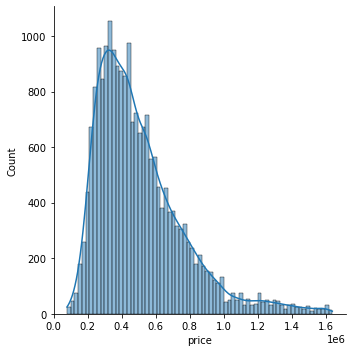

In [424]:
sns.displot(df['price'], kde=True);

# Modeling

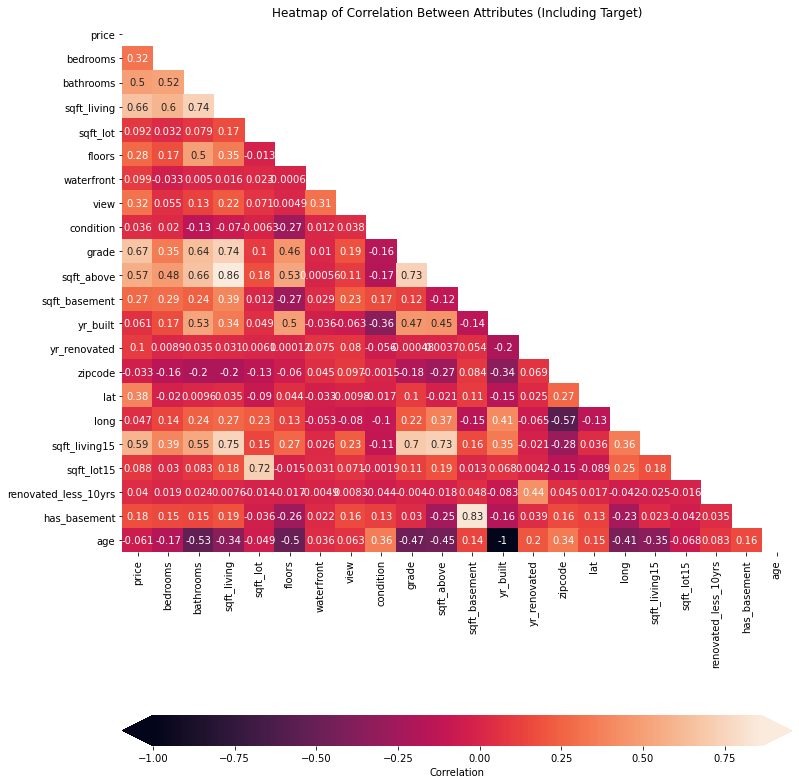

In [425]:
# heatmap_data = pd.concat([y_train, X_train], axis=1)
# corr = heatmap_data.corr()
corr = df.corr()
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 15))
# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

# Helper Functions

In [426]:
def linearity_plot(x, y):
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    cols = 1
    if x.shape[1] % 2 == 0:
        cols = 2
    elif x.shape[1] < 2:
        cols = 1
    else:
        cols = 3
    rows = 1
    if x.shape[1] // cols == 0:
        rows = 1
    elif x.shape[1] % cols > 0:
        rows = x.shape[1] // cols + 1
    else:
        rows = rows = x.shape[1] // cols 
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(10,7), squeeze=False)
    fig.set_tight_layout(True)
    for index, col in enumerate(x.columns):
        ax = axes[index//cols][index%cols]
        ax.scatter(x[col], y, alpha=0.2)
        ax.set_xlabel(col)
        ax.set_ylabel("Listing price")

In [427]:
def train_lr_randomly(data, sample_pt=None, ntimes=100):
    '''
    Takes in features & targets from `data` to train a linear regression with a
    random sample `ntimes`. It then returns a list of R2 scores, RMSEs, and the 
    predictions from a provided data point of features `sample_pt`.
    '''
    # To save all of our predictions
    r2 = []
    rmse = []
    # Only return predictions if there is something to predict (sample_pt given)
    point_preds = [] if (sample_pt is not None) else None

    # We'll repeat this little experiment to see how the model does
    for i in range(ntimes):
        # Creating a random sample of data to train on
        df_sample = data.sample(5000, replace=True)
        y = df_sample.price
        X = df_sample.drop('price', axis=1)

        # Our linear regression model about to be trained
        lr = LinearRegression()
        lr.fit(X, y)

        # Making predictions & evaluating on the data we used to train the model
        y_hat = lr.predict(X)
        rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
        r2.append(lr.score(X, y))

        # Making a prediction on the one point the model definitely never saw
        if sample_pt is not None:
            y_hat_pt = lr.predict(sample_pt)
            # Getting just the single point to add into list
            point_preds.append(y_hat_pt[0])
    
    return r2, rmse, point_preds

# Baseline Model

In [428]:
baseline_y = df['price']
baseline_X = df.drop(['price'], axis=1)

In [429]:
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_X, baseline_y, random_state=42)

In [430]:
scaler = StandardScaler()
baseline_X_train_scaled = scaler.fit_transform(baseline_X_train)
baseline_X_test_scaled = scaler.fit_transform(baseline_X_test)



In [431]:
print(f'Train Mean: {baseline_y_train.mean()}, Test Mean: {baseline_y_test.mean()}')

Train Mean: 505325.3087087843, Test Mean: 512039.5039637599


In [432]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(baseline_X_train_scaled, baseline_y_train)
dummy_regr.predict(baseline_X_train_scaled)
dummy_regr.score(baseline_X_test_scaled, baseline_y_test)

-0.0006578942651938036

In [433]:
baseline_X_train_scaled = pd.DataFrame(baseline_X_train_scaled)
baseline_X_train_scaled.columns = baseline_X.columns
baseline_X_test_scaled = pd.DataFrame(baseline_X_test_scaled)
baseline_X_test_scaled.columns = baseline_X.columns

## *Interpreting the baseline model*

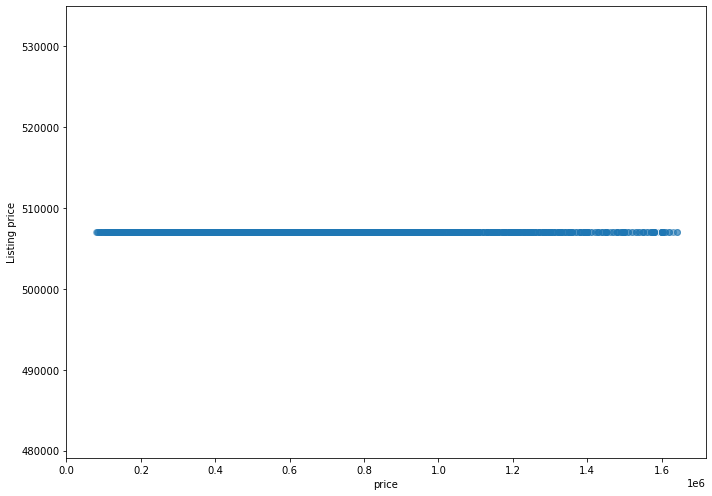

In [434]:
#LINEARITY
df['mean_price']=df['price'].mean()
linearity_plot(df['price'], df['mean_price'])

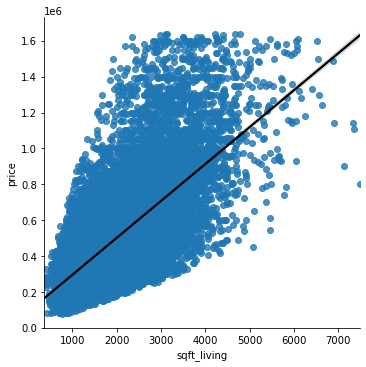

In [435]:
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'black'});

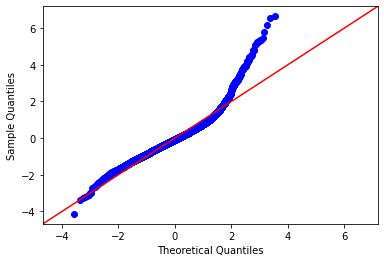

In [436]:
#NORMALITY
# Normal distribution of errors check
baseline_model = LinearRegression()
baseline_model.fit(baseline_X_train_scaled, baseline_y_train)
baseline_model.score(baseline_X_test_scaled, baseline_y_test)
preds = baseline_model.predict(baseline_X_test_scaled)
residuals = (baseline_y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [437]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(baseline_X_train_scaled.values, i) for i in range(baseline_X_train_scaled.shape[1])]
pd.Series(vif, index=baseline_X_train_scaled.columns, name="Variance Inflation Factor")

C:\Users\chris\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


bedrooms                  1.725757
bathrooms                 3.241837
sqft_living             149.768399
sqft_lot                  1.983351
floors                    2.066365
waterfront                1.101259
view                      1.278353
condition                 1.238958
grade                     3.206788
sqft_above              126.135223
sqft_basement            40.923936
yr_built                       inf
yr_renovated              1.340859
zipcode                   1.674664
lat                       1.190267
long                      1.855483
sqft_living15             2.961611
sqft_lot15                2.017249
renovated_less_10yrs      1.230236
has_basement              3.692269
age                            inf
Name: Variance Inflation Factor, dtype: float64

In [438]:
#MULTICOLLINEARITY VIOLATED

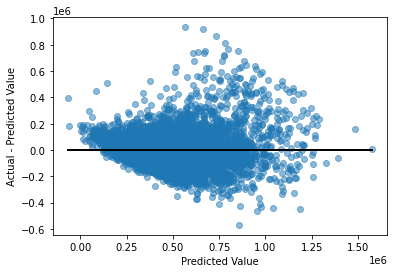

In [439]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(baseline_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

# Mass Tests

In [440]:
baseline = df.copy()
base_sample = baseline.sample(1)
base_sample_price = base_sample.iloc[0, 0]
base_sample_pt = base_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${base_sample_price}')

Price of sample: $247000.0


In [441]:
# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_base, rmse_base, pt_preds_base = train_lr_randomly(
                                                        data=baseline, 
                                                        sample_pt=base_sample_pt,
                                                        ntimes=100                            
)

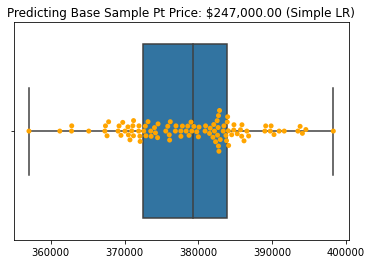

In [442]:
ax = sns.boxplot(x=pt_preds_base);
ax = sns.swarmplot(x=pt_preds_base, color='orange', ax=ax)
ax.set_title(f'Predicting Base Sample Pt Price: ${base_sample_price:,.2f} (Simple LR)');

## First Model: Square Feet Living & Price

In [443]:
first_y = df["price"]
first_formula = ['sqft_living']
first_full_formula = ['price'] + first_formula
first_X = df[first_formula]

In [444]:
first_X_train, first_X_test, first_y_train, first_y_test = train_test_split(first_X, first_y, random_state=42)

In [445]:
scaler = StandardScaler()
first_X_train_scaled = scaler.fit_transform(first_X_train)
first_X_test_scaled = scaler.fit_transform(first_X_test)

In [446]:
first_model = LinearRegression()

# Fit the model on X_train_final and y_train
first_model.fit(first_X_train_scaled, first_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
first_model.score(first_X_test_scaled, first_y_test)

0.43731617821047075

In [447]:
print(f'Train RMSE: {mean_squared_error(first_y_train, first_model.predict(first_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(first_y_test, first_model.predict(first_X_test_scaled), squared=False)}')

Train RMSE: 193057.1182615235
Test RMSE: 196357.78783753506


In [448]:
sm.OLS(first_y_train, sm.add_constant(first_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.264e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        02:01:41   Log-Likelihood:            -2.1597e+05
No. Observations:               15892   AIC:                         4.319e+05
Df Residuals:                   15890   BIC:                         4.320e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.636e+04   4029.623     21.431      0.000    7.85e+04    9.43e+04
sqft_living   207.0564      1.842    112.406      0.000     203.446     210.667
==============================================================================
Omnibus:                     2579.728   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5446.188
Skew:                           0.969   Prob(JB):                         0.00
Kurtosis:                       5.113   Cond. No.                     5.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [449]:
first_X_train_scaled = pd.DataFrame(first_X_train_scaled)
first_X_train_scaled.columns = first_X.columns
first_X_test_scaled = pd.DataFrame(first_X_test_scaled)
first_X_test_scaled.columns = first_X.columns

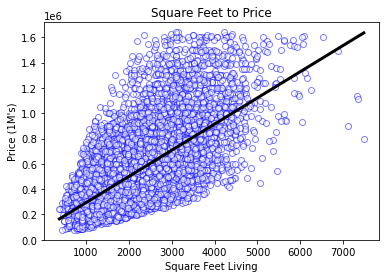

In [450]:
fig, ax = plt.subplots()
ax.scatter(first_X_train[first_formula], first_y_train, alpha=0.5, color ='white', edgecolor='blue')
ax.set_xlabel('Square Feet Living')
ax.set_ylabel("Price (1M's)")
ax.set_title('Square Feet to Price')
plt.plot(np.unique(first_X_train['sqft_living']), np.poly1d(np.polyfit(first_X_train['sqft_living'], first_y_train, 1))
         (np.unique(first_X_train['sqft_living'])),linewidth=3.0,color='black');


## *Interpreting the first model*

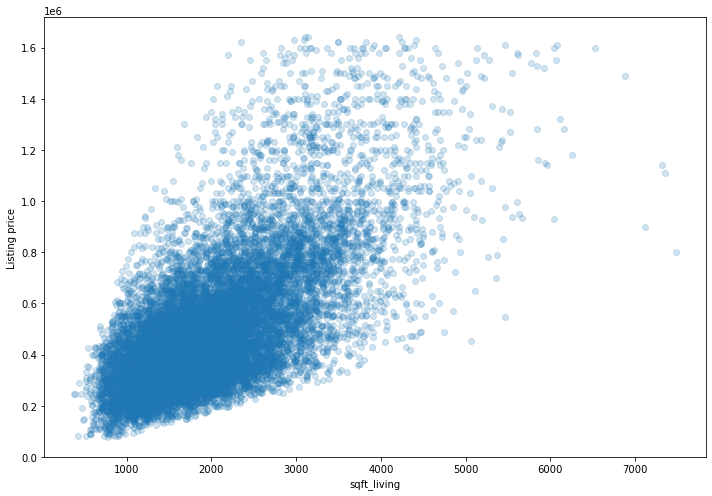

In [451]:
#LINEARITY
linearity_plot(first_X_train, first_y_train)

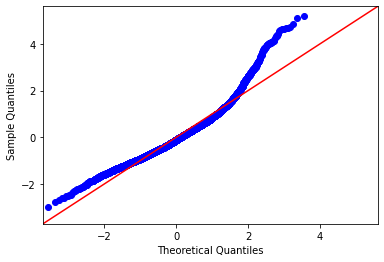

In [452]:
#NORMALITY
import scipy.stats as stats
preds_1st = first_model.predict(first_X_test_scaled)
residuals = (first_y_test - preds_1st)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [453]:
#MULTICOLLINEARITY NOT APPLICABLE

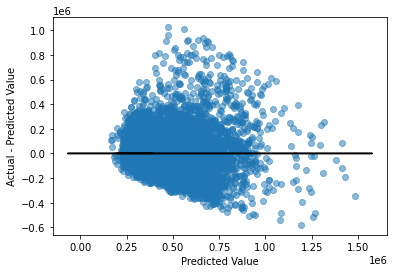

In [454]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds_1st, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(first_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [455]:
first_df = df[first_full_formula]
first_sample = first_df.sample(1)
first_sample_price = first_sample.iloc[0, 0]
first_sample_pt = first_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${first_sample_price}')

Price of sample: $499950.0


In [456]:
# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_first, rmse_first, pt_preds_first = train_lr_randomly(
                                                        data=first_df, 
                                                        sample_pt=first_sample_pt,
                                                        ntimes=100                            
)

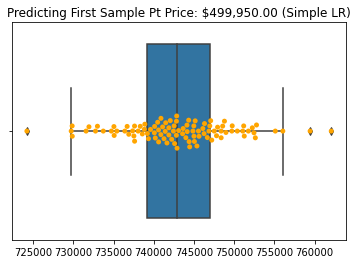

In [457]:
ax = sns.boxplot(x=pt_preds_first);
ax = sns.swarmplot(x=pt_preds_first, color='orange', ax=ax)
ax.set_title(f'Predicting First Sample Pt Price: ${first_sample_price:,.2f} (Simple LR)');

# GOOD MODEL sqft living and Grade

In [458]:
good_y = df["price"]
good_formula = first_formula + ['grade']
good_full_formula = ['price'] + good_formula
good_X = df[good_formula]

In [459]:
good_X_train, good_X_test, good_y_train, good_y_test = train_test_split(good_X, good_y, random_state=42)

In [460]:
scaler = StandardScaler()
good_X_train_scaled = scaler.fit_transform(good_X_train)
good_X_test_scaled = scaler.fit_transform(good_X_test)



In [461]:
good_model = LinearRegression()

# Fit the model on X_train_final and y_train
good_model.fit(good_X_train_scaled, good_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
good_model.score(good_X_test_scaled, good_y_test)

0.5055171743715028

In [462]:
print(f'Train RMSE: {mean_squared_error(good_y_train, good_model.predict(good_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(good_y_test, good_model.predict(good_X_test_scaled), squared=False)}')

Train RMSE: 179752.17213315246
Test RMSE: 184073.60699324406


In [463]:
sm.OLS(good_y_train, sm.add_constant(good_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     8507.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        02:01:42   Log-Likelihood:            -2.1483e+05
No. Observations:               15892   AIC:                         4.297e+05
Df Residuals:                   15889   BIC:                         4.297e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.429e+05   1.14e+04    -39.007      0.000   -4.65e+05   -4.21e+05
sqft_living   114.2943      2.544     44.936      0.000     109.309     119.280
grade        9.433e+04   1909.886     49.388      0.000    9.06e+04    9.81e+04
==============================================================================
Omnibus:                     2717.815   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5976.508
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                       5.242   Cond. No.                     1.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [464]:
good_X_train_scaled = pd.DataFrame(good_X_train_scaled)
good_X_train_scaled.columns = good_X.columns
good_X_test_scaled = pd.DataFrame(good_X_test_scaled)
good_X_test_scaled.columns = good_X.columns

## ASSUMPTIONS

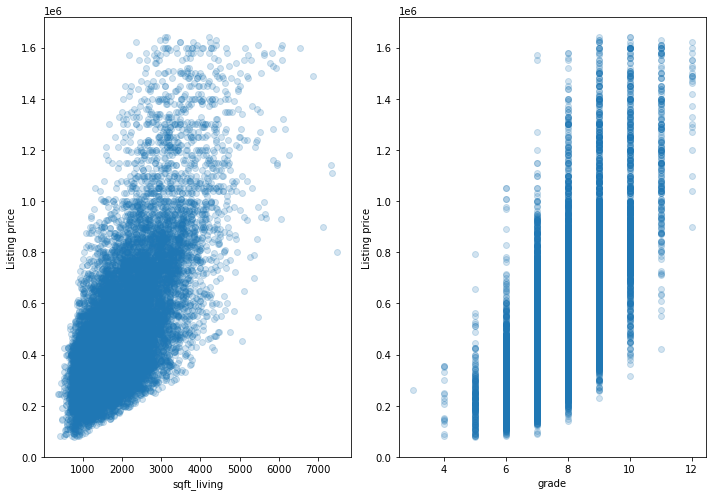

In [465]:
linearity_plot(good_X_train, good_y_train)

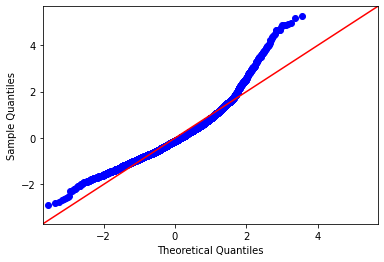

In [466]:
#NORMALITY
good_X_test_scaled = pd.DataFrame(good_X_test_scaled)
preds_good = good_model.predict(good_X_test_scaled)
residuals = (good_y_test - preds_good)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [467]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(good_X_train_scaled.values, i) for i in range(good_X_train_scaled.shape[1])]
pd.Series(vif, index=good_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living    2.199202
grade          2.199202
Name: Variance Inflation Factor, dtype: float64

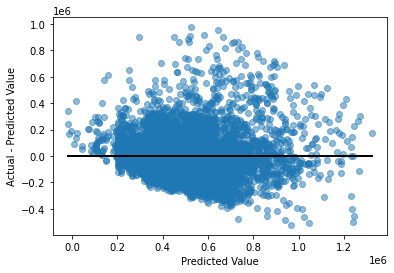

In [468]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_good, residuals, alpha=0.5)
ax.plot(preds_good, [0 for i in range(len(good_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [469]:
#HOMOSCEDASTICITY BORDERLINE

In [470]:
good_df = df[good_full_formula]
good_sample = good_df.sample(1)
good_sample_price = good_sample.iloc[0, 0]
good_sample_pt = good_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${good_sample_price}')

Price of sample: $291000.0


In [471]:
# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_good, rmse_good, pt_preds_good = train_lr_randomly(
                                                        data=good_df, 
                                                        sample_pt=good_sample_pt,
                                                        ntimes=100                            
)

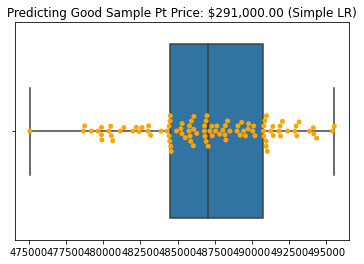

In [472]:
ax = sns.boxplot(x=pt_preds_good);
ax = sns.swarmplot(x=pt_preds_good, color='orange', ax=ax)
ax.set_title(f'Predicting Good Sample Pt Price: ${good_sample_price:,.2f} (Simple LR)');

# Great Model sqft_living, grade, lat

In [473]:
great_y = df["price"]
great_formula = good_formula + ['lat']
great_full_formula = ['price'] + great_formula
great_X = df[great_formula]

In [474]:
great_X_train, great_X_test, great_y_train, great_y_test = train_test_split(great_X, great_y, random_state=42)

In [475]:
scaler = StandardScaler()
great_X_train_scaled = scaler.fit_transform(great_X_train)
great_X_test_scaled = scaler.fit_transform(great_X_test)

In [476]:
great_model = LinearRegression()

# Fit the model on X_train_final and y_train
great_model.fit(great_X_train_scaled, great_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
great_model.score(great_X_test_scaled, great_y_test)

0.6176149195869165

In [477]:
print(f'Train RMSE: {mean_squared_error(great_y_train, great_model.predict(great_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(great_y_test, great_model.predict(great_X_test_scaled), squared=False)}')

Train RMSE: 157835.15561065444
Test RMSE: 161870.00715740043


In [478]:
sm.OLS(great_y_train, sm.add_constant(great_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     8928.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        02:01:44   Log-Likelihood:            -2.1277e+05
No. Observations:               15892   AIC:                         4.255e+05
Df Residuals:                   15888   BIC:                         4.256e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.993e+07   4.29e+05    -69.706      0.000   -3.08e+07   -2.91e+07
sqft_living   124.2534      2.238     55.516      0.000     119.866     128.640
grade        8.037e+04   1689.331     47.574      0.000    7.71e+04    8.37e+04
lat          6.217e+05   9051.041     68.693      0.000    6.04e+05    6.39e+05
==============================================================================
Omnibus:                     4196.020   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13877.959
Skew:                           1.330   Prob(JB):                         0.00
Kurtosis:                       6.726   Cond. No.                     7.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [479]:
great_X_train_scaled = pd.DataFrame(great_X_train_scaled)
great_X_train_scaled.columns = great_X.columns
great_X_test_scaled = pd.DataFrame(great_X_test_scaled)
great_X_test_scaled.columns = great_X.columns

## Assumptions

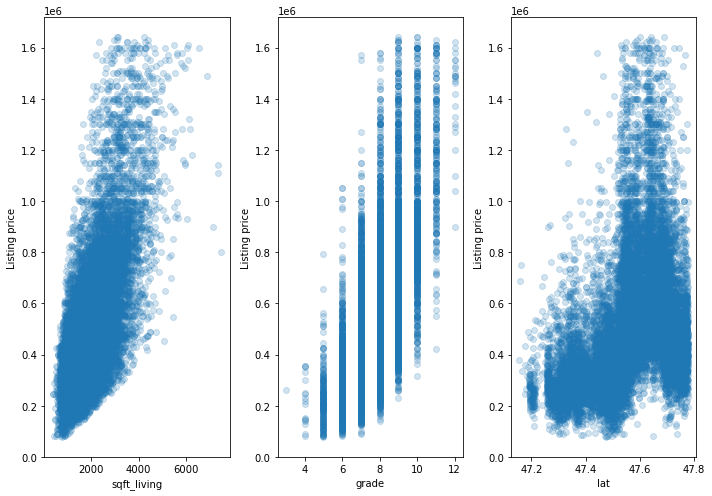

In [480]:
# Linearity
linearity_plot(great_X_train, great_y_train)

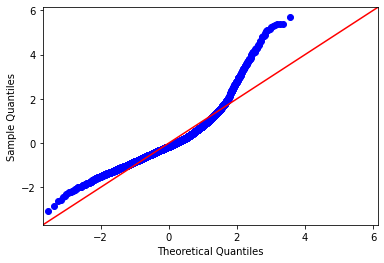

In [481]:
#NORMALITY
great_X_test_scaled = pd.DataFrame(great_X_test_scaled)
preds_great = great_model.predict(great_X_test_scaled)
residuals = (great_y_test - preds_great)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [482]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(great_X_train_scaled.values, i) for i in range(great_X_train_scaled.shape[1])]
pd.Series(vif, index=great_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living    2.208469
grade          2.231483
lat            1.016004
Name: Variance Inflation Factor, dtype: float64

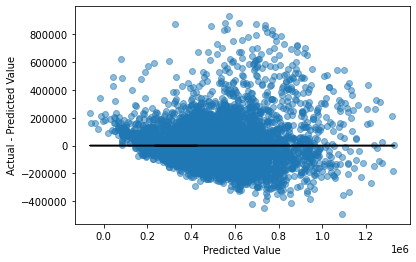

In [483]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_great, residuals, alpha=0.5)
ax.plot(preds_great, [0 for i in range(len(great_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [484]:
#MAYBE ISSUES?

In [485]:
great_df = df[great_full_formula]
great_sample = great_df.sample(1)
great_sample_price = great_sample.iloc[0, 0]
great_sample_pt = great_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${great_sample_price}')

Price of sample: $250000.0


In [486]:
# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_great, rmse_great, pt_preds_great = train_lr_randomly(
                                                        data=great_df, 
                                                        sample_pt=great_sample_pt,
                                                        ntimes=100                            
)

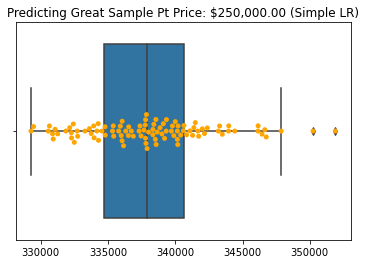

In [487]:
ax = sns.boxplot(x=pt_preds_great);
ax = sns.swarmplot(x=pt_preds_great, color='orange', ax=ax)
ax.set_title(f'Predicting Great Sample Pt Price: ${great_sample_price:,.2f} (Simple LR)');

# Awesome Model sqft_living, grade, lat, view

In [488]:
awesome_y = df["price"]
awesome_formula = great_formula + ['view']
awesome_full_formula = ['price'] + awesome_formula
awesome_X = df[awesome_formula]

In [489]:
awesome_X_train, awesome_X_test, awesome_y_train, awesome_y_test = train_test_split(awesome_X, awesome_y, random_state=42)

In [490]:
scaler = StandardScaler()
awesome_X_train_scaled = scaler.fit_transform(awesome_X_train)
awesome_X_test_scaled = scaler.fit_transform(awesome_X_test)

In [491]:
awesome_model = LinearRegression()

# Fit the model on X_train_final and y_train
awesome_model.fit(awesome_X_train_scaled, awesome_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
awesome_model.score(awesome_X_test_scaled, awesome_y_test)

0.651292861111987

In [492]:
print(f'Train RMSE: {mean_squared_error(awesome_y_train, awesome_model.predict(awesome_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(awesome_y_test, awesome_model.predict(awesome_X_test_scaled), squared=False)}')

Train RMSE: 151834.01300095549
Test RMSE: 154577.52013509593


In [493]:
sm.OLS(awesome_y_train, sm.add_constant(awesome_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     7555.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        02:01:46   Log-Likelihood:            -2.1215e+05
No. Observations:               15892   AIC:                         4.243e+05
Df Residuals:                   15887   BIC:                         4.243e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.017e+07   4.13e+05    -73.047      0.000    -3.1e+07   -2.94e+07
sqft_living   115.1185      2.168     53.094      0.000     110.869     119.368
grade         7.74e+04   1627.261     47.567      0.000    7.42e+04    8.06e+04
lat          6.275e+05   8708.682     72.058      0.000     6.1e+05    6.45e+05
view         6.361e+04   1777.457     35.786      0.000    6.01e+04    6.71e+04
==============================================================================
Omnibus:                     3897.302   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13467.977
Skew:                           1.218   Prob(JB):                         0.00
Kurtosis:                       6.796   Cond. No.                     7.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [494]:
awesome_X_train_scaled = pd.DataFrame(awesome_X_train_scaled)
awesome_X_train_scaled.columns = awesome_X.columns
awesome_X_test_scaled = pd.DataFrame(awesome_X_test_scaled)
awesome_X_test_scaled.columns = awesome_X.columns

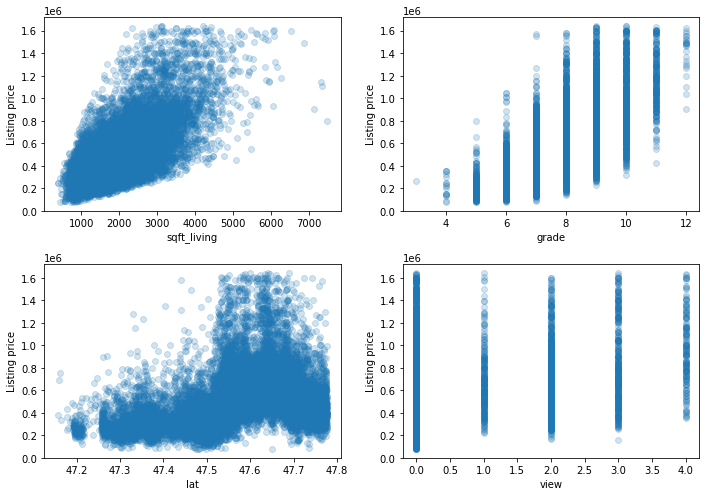

In [495]:
# Linearity
linearity_plot(awesome_X_train, awesome_y_train)


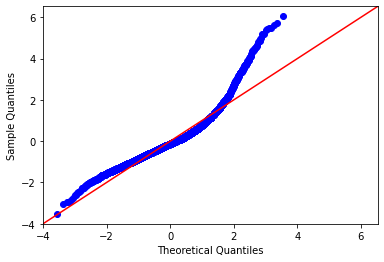

In [496]:
#NORMALITY
awesome_X_test_scaled = pd.DataFrame(awesome_X_test_scaled)
preds_awesome = awesome_model.predict(awesome_X_test_scaled)
residuals = (awesome_y_test - preds_awesome)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [497]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(awesome_X_train_scaled.values, i) for i in range(awesome_X_train_scaled.shape[1])]
pd.Series(vif, index=awesome_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living    2.239509
grade          2.237280
lat            1.016354
view           1.056453
Name: Variance Inflation Factor, dtype: float64

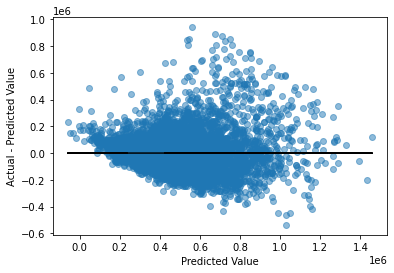

In [498]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_awesome, residuals, alpha=0.5)
ax.plot(preds_awesome, [0 for i in range(len(awesome_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [499]:
awesome_df = df[awesome_full_formula]
awesome_sample = awesome_df.sample(1)
awesome_sample_price = awesome_sample.iloc[0, 0]
awesome_sample_pt = awesome_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${awesome_sample_price}')

Price of sample: $610000.0


In [500]:
# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_awesome, rmse_awesome, pt_preds_awesome = train_lr_randomly(
                                                        data=awesome_df, 
                                                        sample_pt=awesome_sample_pt,
                                                        ntimes=100                            
)

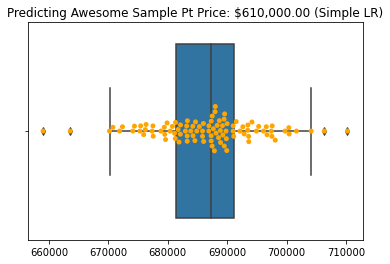

In [501]:
ax = sns.boxplot(x=pt_preds_awesome);
ax = sns.swarmplot(x=pt_preds_awesome, color='orange', ax=ax)
ax.set_title(f'Predicting Awesome Sample Pt Price: ${awesome_sample_price:,.2f} (Simple LR)');

# Amazing Model sqft_living, grade, lat, view, age

In [502]:
amazing_y = df["price"]
amazing_formula = awesome_formula + ['age']
amazing_full_formula = ['price'] + amazing_formula
amazing_X = df[amazing_formula]

In [503]:
amazing_X_train, amazing_X_test, amazing_y_train, amazing_y_test = train_test_split(amazing_X, amazing_y, random_state=42)

In [504]:
scaler = StandardScaler()
amazing_X_train_scaled = scaler.fit_transform(amazing_X_train)
amazing_X_test_scaled = scaler.fit_transform(amazing_X_test)

In [505]:
amazing_model = LinearRegression()

# Fit the model on X_train_final and y_train
amazing_model.fit(amazing_X_train_scaled, amazing_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
amazing_model.score(amazing_X_test_scaled, amazing_y_test)

0.6873733520820424

In [506]:
print(f'Train RMSE: {mean_squared_error(amazing_y_train, amazing_model.predict(amazing_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(amazing_y_test, amazing_model.predict(amazing_X_test_scaled), squared=False)}')

Train RMSE: 143743.49029106615
Test RMSE: 146362.19480734767


In [507]:
sm.OLS(amazing_y_train, sm.add_constant(amazing_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     7111.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        02:01:48   Log-Likelihood:            -2.1128e+05
No. Observations:               15892   AIC:                         4.226e+05
Df Residuals:                   15886   BIC:                         4.226e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.636e+07   4.01e+05    -65.740      0.000   -2.72e+07   -2.56e+07
sqft_living   115.0162      2.053     56.031      0.000     110.993     119.040
grade        1.052e+05   1671.009     62.929      0.000    1.02e+05    1.08e+05
lat           5.41e+05   8488.398     63.732      0.000    5.24e+05    5.58e+05
view         5.013e+04   1711.894     29.285      0.000    4.68e+04    5.35e+04
age          1980.0862     46.179     42.879      0.000    1889.571    2070.602
==============================================================================
Omnibus:                     3478.747   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12786.311
Skew:                           1.067   Prob(JB):                         0.00
Kurtosis:                       6.842   Cond. No.                     7.70e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [508]:
amazing_X_train_scaled = pd.DataFrame(amazing_X_train_scaled)
amazing_X_train_scaled.columns = amazing_X.columns
amazing_X_test_scaled = pd.DataFrame(amazing_X_test_scaled)
amazing_X_test_scaled.columns = amazing_X.columns

## Assumptions

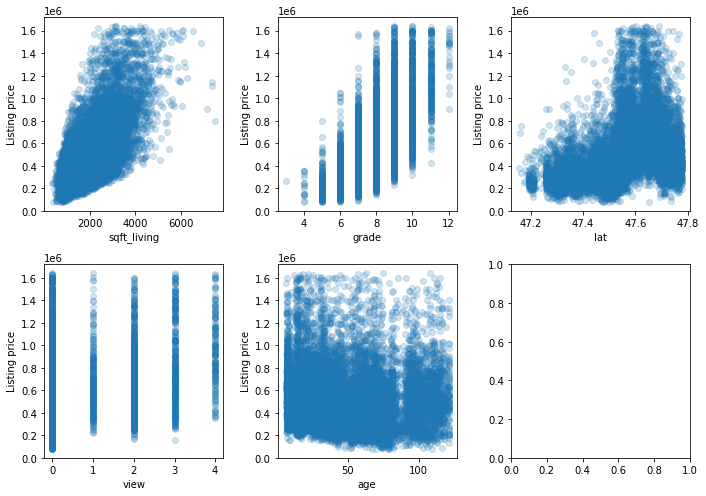

In [509]:
# Linearity
linearity_plot(amazing_X_train, amazing_y_train)

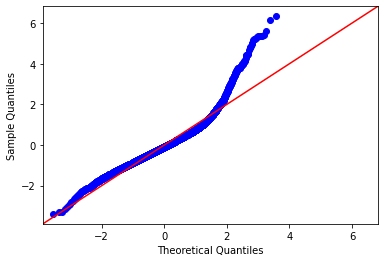

In [510]:
#NORMALITY
amazing_X_test_scaled = pd.DataFrame(amazing_X_test_scaled)
preds_amazing = amazing_model.predict(amazing_X_test_scaled)
residuals = (amazing_y_test - preds_amazing)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [511]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(amazing_X_train_scaled.values, i) for i in range(amazing_X_train_scaled.shape[1])]
pd.Series(vif, index=amazing_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living    2.239512
grade          2.632073
lat            1.077274
view           1.093301
age            1.409408
Name: Variance Inflation Factor, dtype: float64

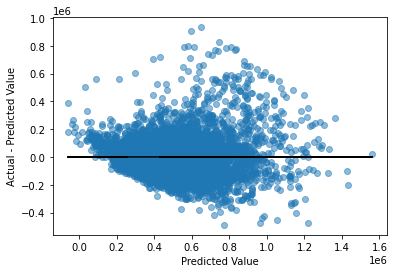

In [512]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_amazing, residuals, alpha=0.5)
ax.plot(preds_amazing, [0 for i in range(len(amazing_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [513]:
amazing_df = df[amazing_full_formula]
amazing_sample = amazing_df.sample(1)
amazing_sample_price = amazing_sample.iloc[0, 0]
amazing_sample_pt = amazing_sample.drop('price', axis=1)

# Show my random sample off
print(f'Price of sample: ${amazing_sample_price}')

Price of sample: $242500.0


In [514]:

# Run 100 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_amazing, rmse_amazing, pt_preds_amazing = train_lr_randomly(
                                                        data=amazing_df, 
                                                        sample_pt=amazing_sample_pt,
                                                        ntimes=100                            
)

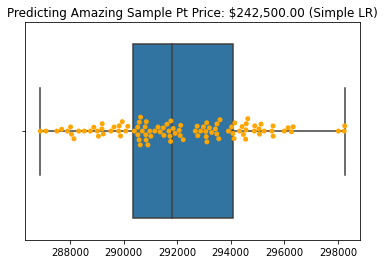

In [515]:
ax = sns.boxplot(x=pt_preds_amazing);
ax = sns.swarmplot(x=pt_preds_amazing, color='orange', ax=ax)
ax.set_title(f'Predicting Amazing Sample Pt Price: ${amazing_sample_price:,.2f} (Simple LR)');

# Regression Results

# Conclusion